In [1]:
from numpy import *
from numpy.random import *
from PlotFuncs import *
import pandas

# Load all stars
df = pandas.read_csv('../data/GAIA_SDSS_Shards.csv')
names = df.group_id.unique()
num_cands = size(names)



# SAVING DATA

# Set up data frames
params = ['x','y','z','dx','dy','dz','vx','vy','vz','sigx','sigy','sigz','feh','dfeh','population','Psun']
nparams = size(params)
dat = zeros(shape=(1,nparams))
df_shards = pandas.DataFrame(dat,columns=params)
shard_names = ' '

# Loop over shards
for i_cand in range(0,num_cands):
    # Get shard
    Cand = df.loc[df['group_id'] == names[i_cand]]
        
    # fit data
    x_meens,x_covs,v_meens,v_covs,fehs,pops,Psun = FitStars(Cand)
    ng = shape(x_meens)[0]

    
    # Add groups to data frame
    if ng==1:
        dat = zeros(shape=(1,nparams))
        shard_names = vstack((shard_names,names[i_cand]))
        sig_x = sqrt(array([x_covs[0,0,0],x_covs[0,1,1],x_covs[0,2,2]]))
        sig_v = sqrt(array([v_covs[0,0,0],v_covs[0,1,1],v_covs[0,2,2]]))
        dat[0,:] = append(append(concatenate((x_meens[0,:],sig_x,v_meens[0,:],sig_v,fehs)),pops),Psun)
        df1 = pandas.DataFrame(dat,columns=params)
    else:
        dat = zeros(shape=(2,nparams))
        shard_names = vstack((shard_names,names[i_cand]+'a'))
        shard_names = vstack((shard_names,names[i_cand]+'b'))
        sig_x = sqrt(array([x_covs[0,0,0],x_covs[0,1,1],x_covs[0,2,2]]))
        sig_v = sqrt(array([v_covs[0,0,0],v_covs[0,1,1],v_covs[0,2,2]]))
        dat[0,:] = append(append(concatenate((x_meens[0,:],sig_x,v_meens[0,:],sig_v,fehs[0,:])),pops[0]),Psun[0])
    
        sig_x = sqrt(array([x_covs[1,0,0],x_covs[1,1,1],x_covs[1,2,2]]))
        sig_v = sqrt(array([v_covs[1,0,0],v_covs[1,1,1],v_covs[1,2,2]]))
        dat[1,:] = append(append(concatenate((x_meens[1,:],sig_x,v_meens[1,:],sig_v,fehs[1,:])),pops[1]),Psun[1])
        
        df1 = pandas.DataFrame(dat,columns=params)
        
    df_shards = df_shards.append(df1,ignore_index=True)
    
# Join names column
df_names = pandas.DataFrame(shard_names,columns=['group_id'])
df_shards = df_names.join(df_shards)
df_shards = df_shards.drop([0]).reset_index(drop=True)
df_shards.to_csv('../data/FitShards.csv',float_format='%.8f',index=False)
df_shards



/Users/ciaranohare/anaconda/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.DeprecatedIn23,


PlotFuncs.py:124: RuntimeWarning: divide by zero encountered in log
  Lsun = log(multivariate_normal.pdf(Sun, mean=xyz, cov=dxyz))



,group_id,x,y,z,dx,dy,dz,vx,vy,vz,sigx,sigy,sigz,feh,dfeh,population,Psun
0,S1,8.920806,0.604960,2.446287,1.624204,1.394310,1.887211,-8.613012,-286.744220,-67.904165,115.303830,49.943061,60.040625,-1.914902,0.269116,34.0,0.596000
1,S2a,9.013901,0.291494,0.191996,1.318838,1.235043,2.766374,0.517358,160.835716,-230.994398,54.081414,19.848461,34.436651,-1.935785,0.252173,61.0,0.161069
2,S2b,9.758727,0.247825,4.813687,2.169180,0.937888,2.436100,-70.934070,153.268579,161.540808,83.907382,29.618110,71.522927,-1.977933,0.264762,12.0,1.471371
3,C2,8.966159,-0.629466,2.270327,1.223339,0.908375,2.552436,-242.429058,109.856005,180.725782,229.202253,35.903725,236.084638,-1.446076,0.135101,22.0,0.486815
4,Rg1,8.271128,0.188856,4.344439,1.052446,1.911693,1.032710,54.077450,-393.767735,68.317811,147.227629,45.703472,149.431652,-1.599781,0.179137,20.0,3.550658
5,Rg2,8.755265,0.763768,3.999930,0.841397,2.014474,3.209622,47.805209,-254.548475,71.783011,110.163736,27.750025,172.117565,-1.603054,0.169484,20.0,1.240382
6,Rg3a,10.489980,-1.172251,4.195824,2.091974,1.992470,1.672119,-222.655118,-234.790772,-97.894732,29.610128,48.620053,90.487648,-1.383442,0.258090,5.0,3.585402
7,Rg3b,8.802282,0.735504,4.179080,1.906984,2.137622,1.487827,141.909012,-293.398305,70.659169,91.531113,59.810427,120.472258,-1.487823,0.202707,11.0,2.915148
8,Rg4,8.203179,1.704662,4.973094,1.565706,1.837100,1.657626,177.636625,-287.908167,117.878249,114.585938,46.009470,162.703812,-1.469073,0.197508,13.0,3.979119
9,Rg5,8.243434,0.323948,1.667891,1.070699,1.385097,2.974793,-9.998542,-82.282544,-0.564432,83.206083,21.250884,162.710129,-2.155706,0.328404,29.0,0.459583


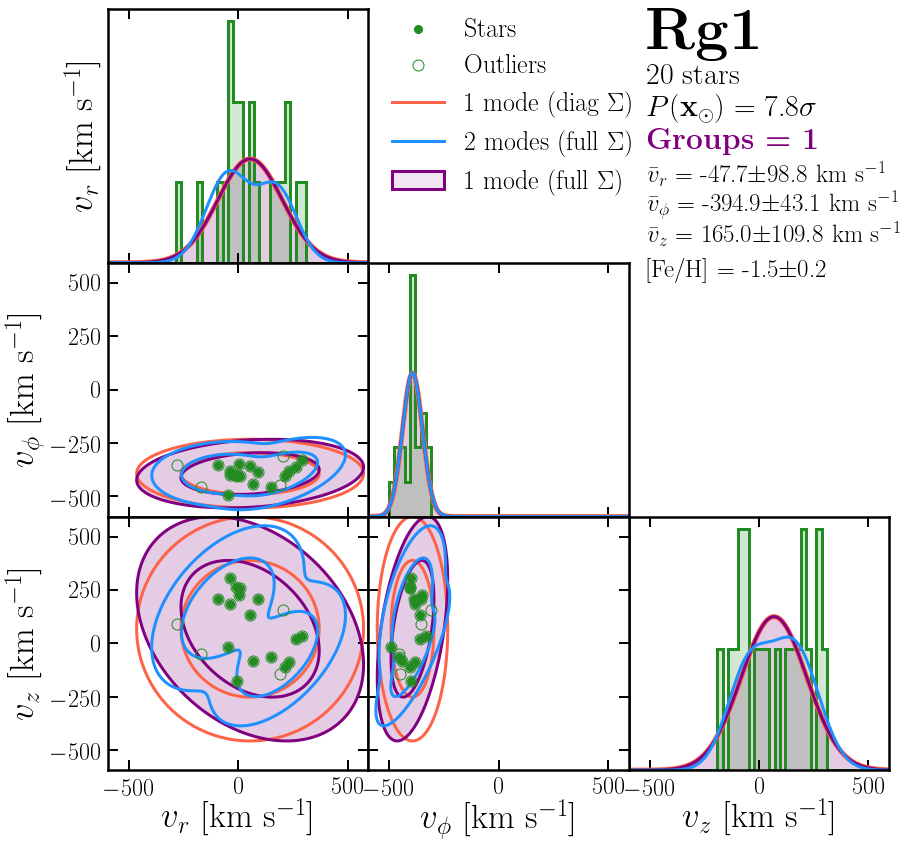

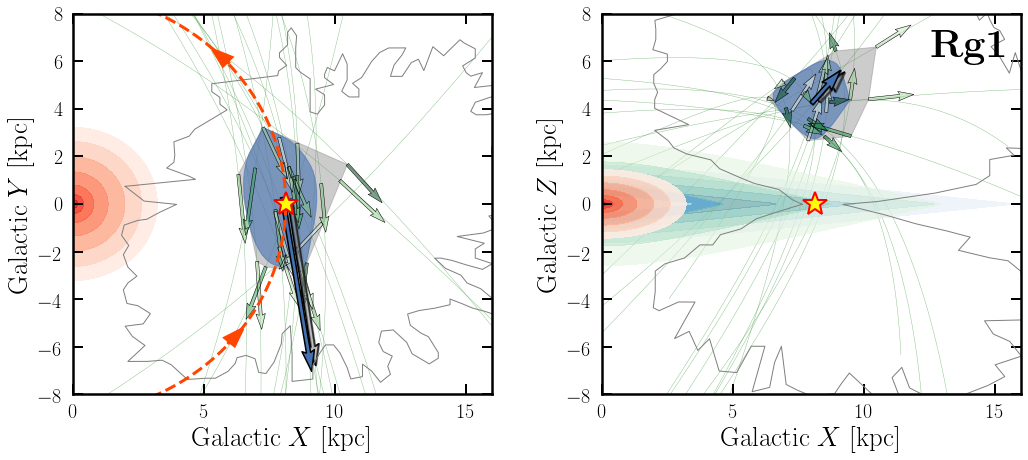

3


In [2]:
colsubs = flipud(cm.Spectral(linspace(0.0,1.0,num_cands)))
for i_cand in range(3,4):
    Cand = df.loc[df['group_id'] == names[i_cand]].reset_index()
    fig = VelocityTriangle(Cand)
    plt.show()
    plt.close(fig)

    fig = XY_XZ(Cand,StarsColour=colsubs[i_cand,:],Grid=False)
    plt.show()
    plt.close(fig)
    print i_cand

In [81]:
# Creating table for latex
nshards = shape(df_shards)[0]
names_str = [None]*nshards
v_str = [None]*nshards
sig_str = [None]*nshards
x_str = [None]*nshards
Psun_str = [None]*nshards
feh_str = [None]*nshards
pop_str = [None]*nshards

vx = df_shards.vx
vy = df_shards.vy
vz = df_shards.vz
sigx = df_shards.sigx
sigy = df_shards.sigy
sigz = df_shards.sigz
x = df_shards.x
y = df_shards.y
z = df_shards.z
feh = df_shards.feh
dfeh = df_shards.dfeh
pops = df_shards.population
Psun = df_shards.Psun

for i in range(0,nshards):
    namei = shard_names[i+1,0]
    if namei.endswith('b'):
        names_str[i] = '{\bf 'namei+'}'
    else:
        names_str[i] = '\hline\hline '+' {\bf '+namei+'}'
    x_str[i] = '$('+'{:.1f}'.format(x[i])+','+'{:.1f}'.format(y[i])+','+'{:.1f}'.format(z[i])+')$'
    v_str[i] = '$('+'{:.1f}'.format(vx[i])+','+'{:.1f}'.format(vy[i])+','+'{:.1f}'.format(vz[i])+')$'
    sig_str[i] = '$('+'{:.1f}'.format(sigx[i])+','+'{:.1f}'.format(sigy[i])+','+'{:.1f}'.format(sigz[i])+')$'
    feh_str[i] = '$'+'{:.1f}'.format(feh[i])+'\pm '+'{:.1f}'.format(dfeh[i])+'$'
    Psun_str[i] = '{:.1f}'.format(Psun[i])
    pop_str[i] = str(int(pops[i]))
    
    #if namei.endswith('b'):
    #    Psun_str[i] += '\hline'
columnsTitles = ['ID',
                 'No. stars',
                 '$(X,Y,Z)$ [kpc]',
                 '$(v_r,v_\phi,v_z)$',
                 '$(\sigma_r,\sigma_\phi,\sigma_z)$',
                 'Fe/H',
                'P']
df_str = pandas.DataFrame(
    {columnsTitles[0]:names_str,
     columnsTitles[1]:pop_str,
     columnsTitles[2]:x_str,
     columnsTitles[3]:v_str,
    columnsTitles[4]:sig_str,
    columnsTitles[5]:feh_str,
    columnsTitles[6]:Psun_str})
#df_str = pandas.DataFrame([x_str,v_str],columns=['Position','Velocity'])
df_str = df_str.reindex(columns=columnsTitles)
df_str.to_csv('../data/FitShards_text.csv',index=False)



In [76]:
df_str

,ID,No. stars,"$(X,Y,Z)$ [kpc]","$(v_r,v_\phi,v_z)$","$(\sigma_r,\sigma_\phi,\sigma_z)$",Fe/H,P
0,,34,"$(8.9,0.6,2.4)$","$(-8.6,-286.7,-67.9)$","$(115.3,49.9,60.0)$",$-1.9\pm0.3$,0.6
1,S1,61,"$(9.0,0.3,0.2)$","$(0.5,160.8,-231.0)$","$(54.1,19.8,34.4)$",$-1.9\pm0.3$,0.2
2,\hline S2a,12,"$(9.8,0.2,4.8)$","$(-70.9,153.3,161.5)$","$(83.9,29.6,71.5)$",$-2.0\pm0.3$,0.2
3,S2b,22,"$(9.0,-0.6,2.3)$","$(-242.4,109.9,180.7)$","$(229.2,35.9,236.1)$",$-1.4\pm0.1$,0.5
4,C2,20,"$(8.3,0.2,4.3)$","$(54.1,-393.8,68.3)$","$(147.2,45.7,149.4)$",$-1.6\pm0.2$,3.6
5,Rg1,20,"$(8.8,0.8,4.0)$","$(47.8,-254.5,71.8)$","$(110.2,27.8,172.1)$",$-1.6\pm0.2$,1.2
6,Rg2,11,"$(8.8,0.7,4.2)$","$(141.9,-293.4,70.7)$","$(91.5,59.8,120.5)$",$-1.5\pm0.2$,2.6
7,\hline Rg3a,5,"$(10.5,-1.2,4.2)$","$(-222.7,-234.8,-97.9)$","$(29.6,48.6,90.5)$",$-1.4\pm0.3$,2.6
8,Rg3b,13,"$(8.2,1.7,5.0)$","$(177.6,-287.9,117.9)$","$(114.6,46.0,162.7)$",$-1.5\pm0.2$,4.0
9,Rg4,29,"$(8.2,0.3,1.7)$","$(-10.0,-82.3,-0.6)$","$(83.2,21.3,162.7)$",$-2.2\pm0.3$,0.5


In [72]:
shape(shard_names)

(70, 1)

In [ ]:
fig = Orbits(Cand,xlim=16,ylim=16,zlim=16,T_Myr=40.0)
plt.show()
plt.close(fig)